## **Week 13: Denoising Diffusion Probabilistic Model**

We'll go over the **original DDPM paper by ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))**, implementing it step-by-step in PyTorch, based on **Phil Wang's [implementation](https://github.com/lucidrains/denoising-diffusion-pytorch)** - which itself is based on the [original TensorFlow implementation](https://github.com/hojonathanho/diffusion). 

**Alright, let's dive in!**

**Reference:**  
* [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion) ([Niels Rogge](https://huggingface.co/nielsr) and [Kashif Rasul](https://huggingface.co/kashif)): 
  * This is the most educative tutorial for DDPM. To make the notebook file you're looking at, I slightly edited this tutorial to suit the practice session.  
* Phil Wang's [implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) 
* The author's [original TensorFlow implementation](https://github.com/hojonathanho/diffusion)

## The whole picture, first!


<p align="center">
    <img src="https://drive.google.com/uc?export=view&id=1rkt777FHjqOpshhJ31gO4DDEzN4OOzu3" width="800" />
</p>

## What is a diffusion model?

* A (denoising) diffusion model is **a neural network learns to gradually denoise data** starting from pure noise. 
* Researchers have been able to achieve remarkable results with them for (un)conditional image/audio/video generation.

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

In a bit more detail for images, the set-up consists of 2 processes:
* **A fixed (or predefined) forward diffusion process $q$** of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
* **A learned reverse denoising diffusion process $p_\theta$**, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.



Both the forward and reverse process indexed by \\(t\\) happen for some number of finite time steps \\(T\\)

* \\(\mathbf{x}_0\\): This is a sample from the distribution of your real data.  
* \\(\mathbf{x}_t\\): The forward process samples some noise from a Gaussian distribution at each time step \\(t\\), which is added to the image of the previous time step.  
* \\(\mathbf{x}_T\\): Given a sufficiently large \\(T\\) and a well behaved schedule for adding noise at each time step, you end up with what is called an [isotropic Gaussian distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) at \\(t=T\\) via a gradual process.

## In more mathematical form

Let's write this down more formally, as ultimately we need a tractable loss function which our neural network needs to optimize. 

**Forward Diffusion Process**

* Let \\(q(\mathbf{x}_0)\\) be the real data distribution, say of "real images". 
* \\(\mathbf{x}_0 \sim q(\mathbf{x}_0)\\): We can sample from this distribution to get an image. 
* \\(\beta_t\\) defines a so-called **"variance schedule"**: linear, quadratic, cosine, etc.
* We define the forward diffusion process \\(q(\mathbf{x}_t | \mathbf{x}_{t-1})\\) which adds Gaussian noise at each time step \\(t\\), according to a known variance schedule \\(0 < \beta_1 < \beta_2 < ... < \beta_T < 1\\) as \\(q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}\\)

    * Basically, each new (slightly noiser) image at time step \\(t\\) is drawn from a **conditional Gaussian distribution** with \\(\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}\\) and \\(\sigma^2_t = \beta_t\\)  

* We can parametrize \\(\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}\\) by sampling \\(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\)

**Reverse Diffusion Process**

* Now, if we knew the conditional distribution \\(p(\mathbf{x}_{t-1} | \mathbf{x}_t)\\), then we could run the process in reverse: by sampling some random Gaussian noise \\(\mathbf{x}_T\\), and then gradually "denoise" it so that we end up with a sample from the real distribution \\(\mathbf{x}_0\\).

* However, we don't know \\(p(\mathbf{x}_{t-1} | \mathbf{x}_t)\\). It's **intractable** since it requires knowing the distribution of all possible images in order to calculate this conditional probability. 
* Hence, we're going to leverage **a neural network to approximate (learn) this conditional probability distribution**, let's call it \\(p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)\\), with \\(\theta\\) being the parameters of the neural network, updated by gradient descent. 

**Neural Network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\)**

* Ok, so we need a neural network to represent a (conditional) probability distribution of the backward process. 
* If we assume this reverse process is Gaussian as well, then recall that any Gaussian distribution is defined by 2 parameters:
  * a mean parametrized by \\(\mu_\theta\\);
  * a variance parametrized by \\(\Sigma_\theta\\);

* so we can parametrize the process as 
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
where the mean and variance are also conditioned on the noise level \\(t\\).
*  In DDPM, the neural network only learn (represent) the mean \\(\mu_\theta\\) of this conditional probability distribution

## Defining an objective function (by reparametrizing the mean)

* The **variational lower bound** (also called **ELBO**) can be used to minimize the negative log-likelihood with respect to ground truth data sample \\(\mathbf{x}_0\\).
* The ELBO for this process is a sum of losses at each time step \\(t\\), \\(L = L_0 + L_1 + ... + L_T\\).(please refer to [VAE](https://arxiv.org/abs/1312.6114) for further details regarding ELBO).
* Each term (except for \\(L_0\\)) of the loss is actually the **KL divergence between 2 Gaussian distributions** which can be written explicitly as an L2-loss with respect to the means!
*  During training, we can **optimize random terms of the loss function \\(L\\)** by its "nice property" 
    * In other words, to randomly sample \\(t\\) during training and optimize \\(L_t\\).
    * We can sample \\(\mathbf{x}_t\\) at any arbitrary noise level conditioned on \\(\mathbf{x}_0\\) (since sums of Gaussians is also Gaussian).  
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$ with \\(\alpha_t := 1 - \beta_t\\) and \\(\bar{\alpha}t := \Pi_{s=1}^{t} \alpha_s\\)

* Moreover, we can instead reparametrize the mean to make the neural network learn (predict) the added noise.
    * This means that our neural network becomes a noise predictor,
    $$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2.$$
    * rather than a (direct) mean predictor which computes the mean as :

$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$

## Training 
The training algorithm now looks as follows:


<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="500" />
</p>

In other words:
* We take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* We sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* We sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* The neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$

## The neural network

* The neural network needs to take in a noised image at a particular time step and return the predicted noise. 
* Note that the predicted noise is a tensor that has the same size/resolution as the input image. 
* So use [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)!: the DDPM authors went for a [U-Net](https://arxiv.org/abs/1505.04597).

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="400" />
</p>

As can be seen, a U-Net model first downsamples the input (i.e. makes the input smaller in terms of spatial resolution), after which upsampling is performed.    

Below, we implement this network, step-by-step.

In [1]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

import os
import numpy as np
import random
from PIL import Image
import requests

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Network helpers

* Some helper functions and classes which will be used when implementing the neural network. 
* `Residual` module simply adds the input to the output of a particular function (in other words, adds a residual connection to a particular function).
* Aliases for the up- and downsampling operations.

In [2]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

* The parameters of the neural network are shared across time (noise level). 
* So, the authors employ sinusoidal position embeddings encoding $t$ to make the network "know" at which particular time step (noise level) it is operating, for every image in a batch.
* The `SinusoidalPositionEmbeddings` module takes 
    * input: A tensor of shape `(batch_size, 1)` (i.e. the noise levels of several noisy images in a batch), 
    * output: A tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. 
    * The output will be added to each residual block, as we will see further.

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block

The core building block of the U-Net model. 
* The DDPM authors employed a Wide ResNet block ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)).
* [Phil Wang (Lucidrains)](https://github.com/lucidrains) decided to also add support for a ConvNeXT block ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)) achieving great success in the image domain.

In [4]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

The attention module, which the DDPM authors added in between the convolutional blocks.
* Regular multi-head self-attention([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)): time- and memory requirements scale quadratic.



In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

### Group normalization

* The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). 
* `PreNorm` class will be used to apply groupnorm before the attention layer, as we'll see further. 

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now, we've defined all building blocks (position embeddings, ResNet/ConvNeXT blocks, attention and group normalization).  

It's time to define the entire neural network. 

* The job of the network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) is to take in a batch of noisy images + noise levels, and output the noise added to the input
* More formally: The network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
1. A convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
1. A sequence of downsampling stages are applied.
    * Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
1. At the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
1. A sequence of upsampling stages are applied. 
    * Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
1. Finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.



In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, Attention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, Attention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Defining the forward diffusion process

* The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$. 
* This happens according to a **variance schedule**. 
    * Below, we define various schedules for the $T$ timesteps, as well as corresponding variables which we'll need, such as cumulative variances.
    * The original DDPM authors employed a linear schedule (from $\beta_1 = 10^{−4}$ to $\beta_T = 0.02$). 
    * [Nichol et al., 2021](https://arxiv.org/abs/2102.09672) showed that employing a cosine schedule lead to better results.


In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with,
* Let's use the linear schedule for \\(T=200\\) time steps 
* Define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). 
* Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). 
* Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [9]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [10]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [11]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Define a PyTorch Dataset + DataLoader

Here we define a regular [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). The dataset simply consists of images from a real dataset, like Fashion-MNIST, CIFAR-10 or ImageNet, scaled linearly to \\([−1, 1]\\).

* Each image is resized to the same size. 
* Randomly and horizontally flipping the images improve sample quality slightly.

Here we use the 🤗 [Datasets library](https://huggingface.co/docs/datasets/index) to easily load the Fashion MNIST dataset from the [hub](https://huggingface.co/datasets/fashion_mnist). This dataset consists of images which already have the same resolution, namely 28x28.

In [12]:
from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [13]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [14]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


torch.Size([1, 28, 28])


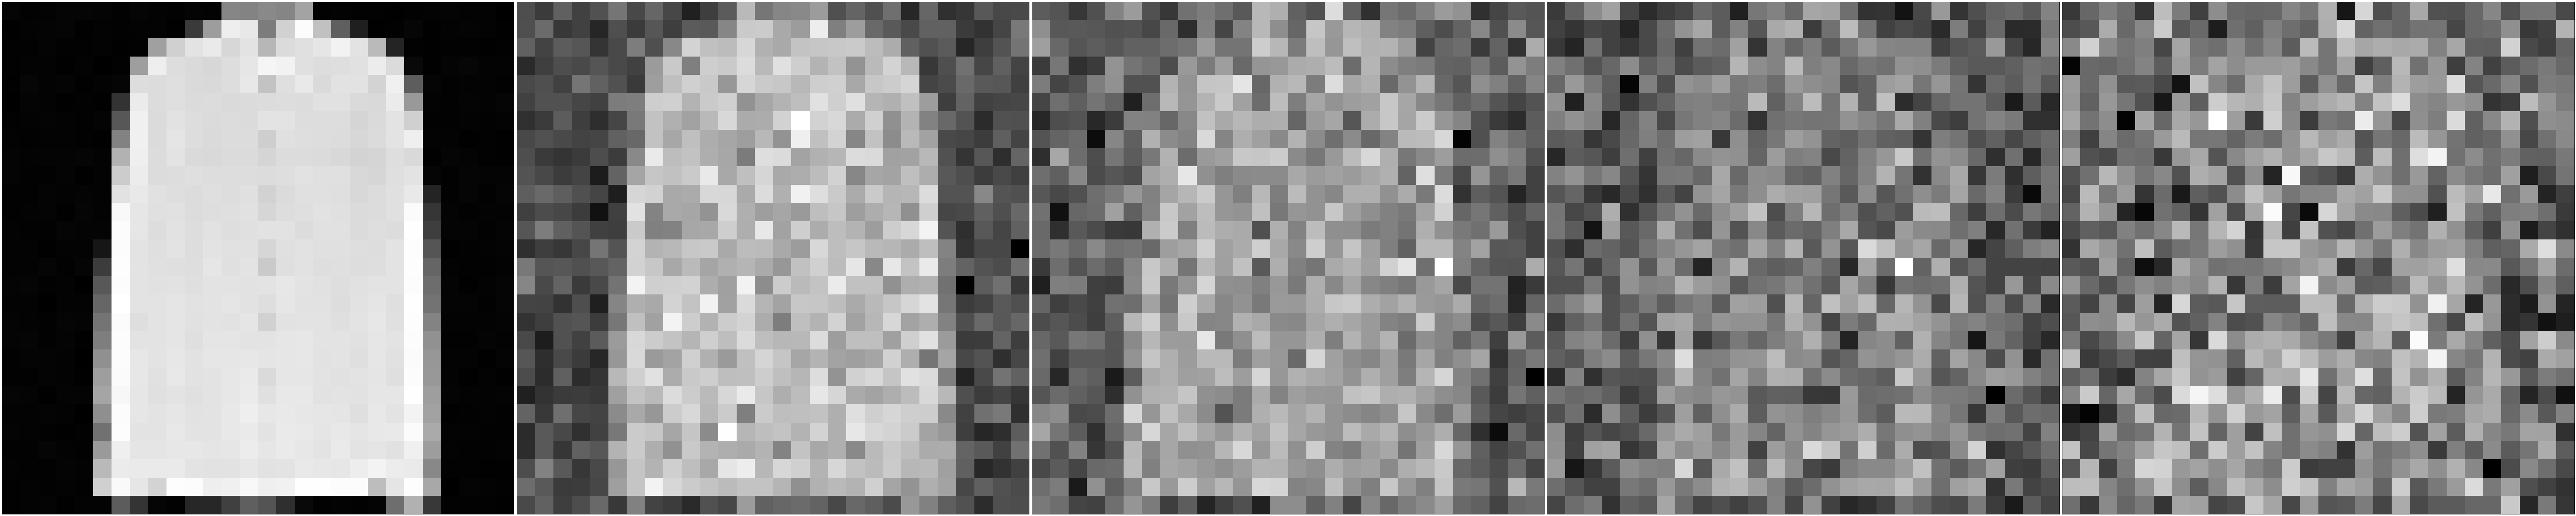

In [15]:
def get_noisy_image(x_start, t):
    x_noisy = q_sample(x_start, t=t)
    return x_noisy

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(140, 140), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = img.squeeze(0)  # Remove the channel dimension
            ax.imshow(img, **imshow_kwargs, cmap="gray")
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

x_start = next(iter(dataloader))["pixel_values"][5]
print(x_start.shape)
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

## Sampling
Sampling is summarized in the paper as Algorithm 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

* Generating new images from a diffusion model happens by reversing the diffusion process
* We start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. 
* As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor (remember that the variance is known ahead of time).

* Ideally, we end up with an image that looks like it came from the real data distribution.

The code below implements this.

In [16]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Train the model

Next, we train the model in regular PyTorch fashion.  
Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).


In [17]:
from torch.optim import Adam
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Let's start training!

In [18]:
from torchvision.utils import save_image

epochs = 10

for epoch in range(epochs):
    print(f'\nepoch: {epoch}')
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print(f"\tLoss: {loss.item():.4f} / step: {step:4d}")

        loss.backward()
        optimizer.step()


epoch: 0
	Loss: 0.4548 / step:    0
	Loss: 0.1253 / step:  100
	Loss: 0.0772 / step:  200
	Loss: 0.0738 / step:  300
	Loss: 0.0582 / step:  400

epoch: 1
	Loss: 0.0620 / step:    0
	Loss: 0.0563 / step:  100
	Loss: 0.0650 / step:  200
	Loss: 0.0546 / step:  300
	Loss: 0.0493 / step:  400

epoch: 2
	Loss: 0.0496 / step:    0
	Loss: 0.0478 / step:  100
	Loss: 0.0449 / step:  200
	Loss: 0.0453 / step:  300
	Loss: 0.0563 / step:  400

epoch: 3
	Loss: 0.0458 / step:    0
	Loss: 0.0523 / step:  100
	Loss: 0.0428 / step:  200
	Loss: 0.0476 / step:  300
	Loss: 0.0568 / step:  400

epoch: 4
	Loss: 0.0385 / step:    0
	Loss: 0.0394 / step:  100
	Loss: 0.0420 / step:  200
	Loss: 0.0534 / step:  300
	Loss: 0.0531 / step:  400

epoch: 5
	Loss: 0.0456 / step:    0
	Loss: 0.0443 / step:  100
	Loss: 0.0481 / step:  200
	Loss: 0.0456 / step:  300
	Loss: 0.0537 / step:  400

epoch: 6
	Loss: 0.0461 / step:    0
	Loss: 0.0522 / step:  100
	Loss: 0.0410 / step:  200
	Loss: 0.0392 / step:  300
	Loss: 0.037

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [19]:
# sample 64 images
sampling_batch_size = 64
img_shape = (sampling_batch_size, channels, image_size, image_size)
samples = p_sample_loop(model, shape=img_shape)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

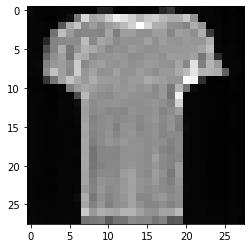

In [20]:
# show a random one
random_index = 2
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

Keep in mind that the dataset we trained on is pretty low-resolution (28x28).

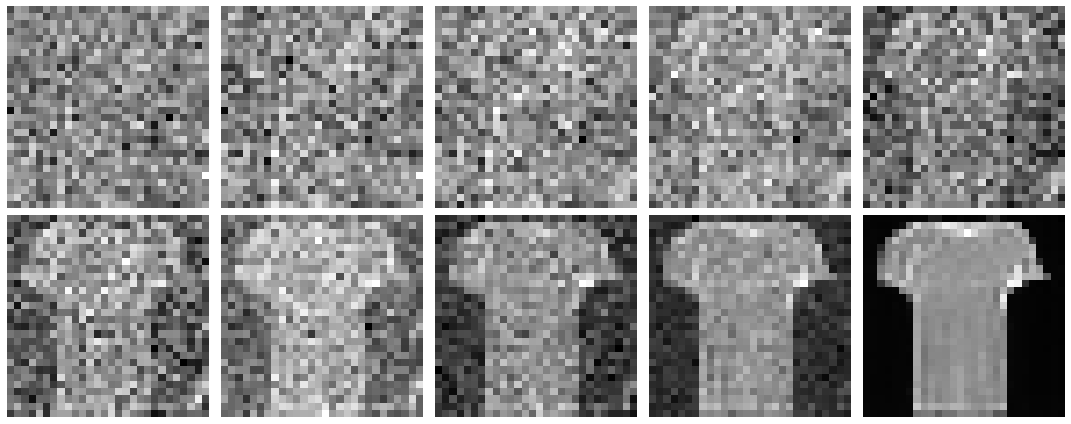

In [21]:
timesteps = len(samples)  
image_size, channels = 28, 1 
num_images_to_display = 10 

indices = np.linspace(0, timesteps - 1, num_images_to_display, dtype=int)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img = samples[indices[i]][random_index].squeeze()
    ax.imshow(img, cmap="gray")
    ax.axis('off') 

plt.tight_layout()
plt.show()

Seems like the model is capable of generating a nice T-shirt!

<img src="https://drive.google.com/uc?id=1eyonQWhfmbQsTq8ndsNjw5QSRQ9em9Au" width="500" />

# Follow-up reads

Note that the DDPM paper showed that diffusion models are a promising direction for (un)conditional image generation. This has since then (immensely) been improved, most notably for text-conditional image generation. Below, we list some important (but far from exhaustive) follow-up works:

### Papers
- Improved Denoising Diffusion Probabilistic Models ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)): finds that learning the variance of the conditional distribution (besides the mean) helps in improving performance
- Cascaded Diffusion Models for High Fidelity Image Generation ([Ho et al., 2021](https://arxiv.org/abs/2106.15282)): introduce cascaded diffusion, which comprises a pipeline of multiple diffusion models that generate images of increasing resolution for high-fidelity image synthesis
- Diffusion Models Beat GANs on Image Synthesis ([Dhariwal et al., 2021](https://arxiv.org/abs/2105.05233)): show that diffusion models can achieve image sample quality superior to the current state-of-the-art generative models by improving the U-Net architecture, as well as introducing classifier guidance
- Classifier-Free Diffusion Guidance ([Ho et al., 2021](https://openreview.net/pdf?id=qw8AKxfYbI)): shows that you don't need a classifier for guiding a diffusion model by jointly training a conditional and an unconditional diffusion model with a single neural network
- Hierarchical Text-Conditional Image Generation with CLIP Latents (DALL-E 2) ([Ramesh et al., 2022](https://cdn.openai.com/papers/dall-e-2.pdf)): use a prior to turn a text caption into a CLIP image embedding, after which a diffusion model decodes it into an image
- Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding (ImageGen) ([Saharia et al., 2022](https://arxiv.org/abs/2205.11487)): shows that combining a large pre-trained language model (e.g. T5) with cascaded diffusion works well for text-to-image synthesis
- GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models([GLIDE](https://arxiv.org/abs/2112.10741))
- High-Resolution Image Synthesis with Latent Diffusion Models: 
([Rombach et al., 2021](https://arxiv.org/abs/2112.10752))

Note that this list only includes important works until the time of writing, which is June 7th, 2022.

For now, it seems that the main (perhaps only) disadvantage of diffusion models is that they require multiple forward passes to generate an image (which is not the case for generative models like GANs). However, there's [research going on](https://arxiv.org/abs/2204.13902) that enables high-fidelity generation in as few as 10 denoising steps.

### Other helpful materials (project page, article...)
* [DALL-E 2](https://openai.com/dall-e-2/) by OpenAI
* [Latent Diffusion](https://github.com/CompVis/latent-diffusion) by the University of Heidelberg
* [ImageGen](https://imagen.research.google/) by Google Brain
* [Diffusion models are autoencoders](https://benanne.github.io/2022/01/31/diffusion.html)
* https://yang-song.net/blog/2021/score/
* https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

